# YouBike Dispatching Plan by using Google OR-Tools

After we got the predicted demands from the previous model, we can start to make the dispatching plan for YouBike. Here we're going to use Google OR-Tools, which is a free open source for solving a bunch of operations research problems such as linear optimization, integer programming, traveling salesman problem, network flows, etc. 

The problem we're solving here is a complicated capacitated vehicle routing problem, or just called it CVRP for short. Just as its name implies, in a CVRP, vehicles have a limited carrying capacity, and these vehicles need to pick up or deliver items at various locations. In our case, a truck can load at most 40 bikes, and these trucks need to deliver bikes to every YouBike station where lots of people will rent bikes during the period. In other words, the trucks have to deliver bikes according to different demands at each station. 

Now let me introduce how we implement the Google OR-Tool to solve this problem.

## Dataframe

First let's take a quick look at the dataframe we have for this problem.

In [1]:
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt

df = pd.read_csv('./count_data.csv')
station = pd.read_csv('./ubike_station.csv')
# Aquire the number of demands
df['demand'] = df['rent_count'] - df['return_count']

In [2]:
print(df[20:30])

    Unnamed: 0  id  time  rent_count  return_count  demand
20          20   1    20        1201           846     355
21          21   1    21        1454           794     660
22          22   1    22        1083           682     401
23          23   1    23         535           353     182
24          24   2     0         292           176     116
25          25   2     1         190            75     115
26          26   2     2         104            47      57
27          27   2     3          88            62      26
28          28   2     4          74            53      21
29          29   2     5          79            80      -1


The dataframe "df" comes from the predictions of our model introduced in the previous section. It includes the renting counts and returning counts of bikes at each station every hour. Column "id" stands for the station id. Column "time" stands for each hour in a day. In addition, we create a column called "demand", which is calculated by subtracting "return_count" from "rent_count." This column implies roughly how many bikes might be needed at each station during the period.

In [3]:
print(station[:5])

   Unnamed: 0  act                                    ar  \
0           1    1                         忠孝東路/松仁路(東南側)   
1           2    1                     忠孝東路四段/光復南路口(西南側)   
2           3    1           台北市政府東門(松智路) (鄰近信義商圈/台北探索館)   
3           4    1  市府路/松壽路(西北側)(鄰近台北101/台北世界貿易中心/台北探索館)   
4           5    1      松仁路/松仁路95巷(東南側)(鄰近信義商圈/台北信義威秀影城)   

                                                aren  bemp        lat  \
0  The S.W. side of Road Zhongxiao East Road & Ro...    55  25.040858   
1                Sec,4. Zhongxiao E.Rd/GuangFu S. Rd    31  25.041254   
2    Taipei City Government Eastgate (Song Zhi Road)    17  25.037797   
3      The N.W. side of Road Shifu & Road Song Shou.    25  25.036036   
4  The S.E. side of Road Songren & Ln. 95, Songre...    31  25.036564   

          lng            mday sarea      sareaen  sbi             sna  \
0  121.567904  20190502212130   信義區  Xinyi Dist.  125    捷運市政府站(3號出口)   
1  121.557420  20190502212127   大安區   Daan Dist.   17 

Another dataframe "station" is an open data from the government for the detailed information of all the YouBike stations in Taipei. In the data, we can find each station's name and location in longitude and latitude, which will be used later for the calculation of distances between each station.

In [4]:
# Merge df & station dataframe
temp_merge = pd.merge(df, station, left_on="id", right_on="sno", how='left')
df_merge = temp_merge[['id', 'time', 'rent_count', 'return_count', 'demand', 'lat', 'lng', 'sareaen', 'snaen']].dropna()
# Route planning for Daan District 7:00 - 8:00
df_ta = df_merge[(df_merge['sareaen'] == 'Daan Dist.') & (df_merge['time'] == 7) & (df_merge['demand'] >= 50)].reset_index()

For easier computation, we merge 2 dataframes (this is feasible since they share the same station id). The merged dataframe "df_merge" is shown below.  To make a more simple demonstration of the route planning, we'll take 大安 District during 7 a.m. to 8 a.m. for example. The example dataframe "df_ta" is shown below.

In [5]:
print(df_merge[20:25])

    id  time  rent_count  return_count  demand        lat         lng  \
20   1    20        1201           846     355  25.040858  121.567904   
21   1    21        1454           794     660  25.040858  121.567904   
22   1    22        1083           682     401  25.040858  121.567904   
23   1    23         535           353     182  25.040858  121.567904   
24   2     0         292           176     116  25.041254  121.557420   

        sareaen                                      snaen  
20  Xinyi Dist.    MRT Taipei City Hall Stataion(Exit 3)-2  
21  Xinyi Dist.    MRT Taipei City Hall Stataion(Exit 3)-2  
22  Xinyi Dist.    MRT Taipei City Hall Stataion(Exit 3)-2  
23  Xinyi Dist.    MRT Taipei City Hall Stataion(Exit 3)-2  
24   Daan Dist.  MRT S.Y.S Memorial Hall Stataion(Exit 2.)  


In [6]:
print(df_ta)

    index   id  time  rent_count  return_count  demand        lat         lng  \
0     463   20     7         346           207     139  25.025896  121.543293   
1     703   30     7         351           247     104  25.017054  121.544352   
2     727   31     7         224           167      57  25.022413  121.534560   
3     751   32     7         432           239     193  25.023884  121.553161   
4     871   37     7         289           174     115  25.033700  121.528988   
5    1063   45     7         915           581     334  25.014760  121.534538   
6    1255   54     7         257            73     184  25.028798  121.538073   
7    1663   71     7         323           216     107  25.032985  121.554204   
8    1903   81     7         280           128     152  25.020547  121.528552   
9    1999   85     7         204           145      59  25.033362  121.549110   
10   2623  111     7          92            33      59  25.040184  121.543497   
11   3031  128     7        

## Plot the demands at each YouBike station in Daan Dist. at 07:00 - 08:00

Let's plot it to get a quick glance of it. In this figure, you'll find all the stations in 大安 District which has a demand greater than 50 during 7 a.m. to 8 a.m., like there's 捷運科技大樓站 in the middle, 羅斯福新生南交叉路口 and 捷運公館站 in the bottom left. Every blue dot is a station. The size of the blue dot simply means the demands of the station. The bigger the dot is, the larger the demand is.

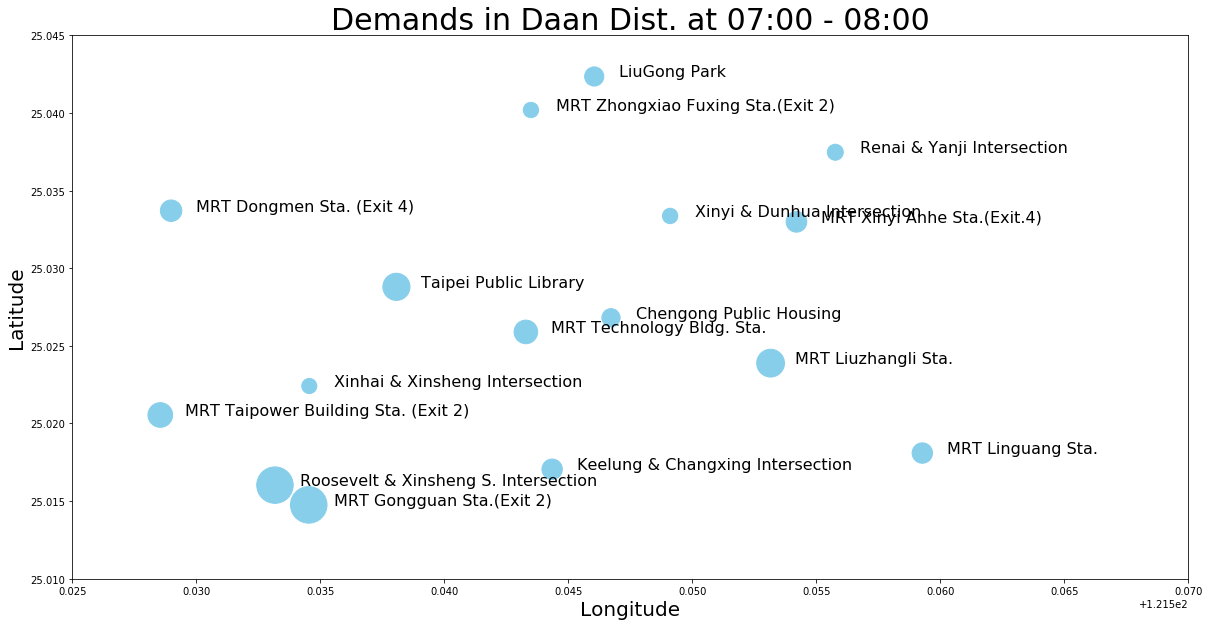

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Demands in Daan Dist. at 07:00 - 08:00', fontsize=30)
# The larger the demand is, the bigger the blue circle is.
ax.scatter(df_ta['lng'], df_ta['lat'], s=df_ta['demand']*4, color='skyblue')
ax.set(xlim=[121.525, 121.57], ylim=[25.01, 25.045])
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
# Annotate the station index
for i, txt in enumerate(df_ta['snaen']):
    ax.annotate(txt, (df_ta['lng'][i] + 0.001, df_ta['lat'][i]), fontsize=16)

## Distance matrix

Recall that our problem is to find an assignment of routes to vehicles that has the shortest total distance, and such that the total amount a vehicle is carrying never exceeds its capacity. So now we need to create a distance matrix of all stations here for the OR-Tool to find the shortest total distance.

First we define the function "location_tuple" to transform the data to tuple type for an easier calculation. 

In [8]:
def location_tuple(loc_df):
    location = []
    for i in range(len(loc_df)):
        location.append(tuple([loc_df['lat'][i], loc_df['lng'][i]]))
    return location

Then we have the function "haversine_distance" calculate the Haversine Distance between each station according to their longitude and latitude. 

In [9]:
def haversine_distance(position_1, position_2):
    # 地球半徑 (km)
    R = 6373.0
    lat1 = math.radians(position_1[0])
    lon1 = math.radians(position_1[1])
    lat2 = math.radians(position_2[0])
    lon2 = math.radians(position_2[1])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # 地表直線距離
    distance = R * c
    return(distance)

Finally we have the function "compute_haversine_distance_matrix" turn the locations into a distance matrix. 

In [10]:
def compute_haversine_distance_matrix(locations):
    """Creates callback to return distance between points."""
    distances = [0] * len(locations)
    for from_counter, from_node in enumerate(locations):
        distances[from_counter] = [0] * len(locations)
        for to_counter, to_node in enumerate(locations):
            if from_counter == to_counter:
                distances[from_counter][to_counter] = 0
            else:
                # Haversine distance
                distances[from_counter][to_counter] = int(1000 * haversine_distance(from_node, to_node))
    return distances

In [11]:
# Demo distance matrix
distance_matrix_demo = compute_haversine_distance_matrix(location_tuple(df_ta))
print('Distance matrix:')
for i in range(len(distance_matrix_demo)):
    print(distance_matrix_demo[i])
print('')

Distance matrix:
[0, 989, 961, 1019, 1682, 1520, 617, 1353, 1600, 1016, 1589, 360, 1497, 1829, 1850, 1799]
[989, 0, 1152, 1168, 2413, 1021, 1451, 2031, 1639, 1876, 2574, 1111, 1132, 1509, 2817, 2545]
[961, 1152, 0, 1881, 1375, 851, 793, 2302, 640, 1906, 2172, 1320, 723, 2537, 2500, 2715]
[1019, 1168, 1881, 0, 2669, 2133, 1615, 1017, 2507, 1130, 2058, 725, 2195, 891, 2174, 1533]
[1682, 2413, 1375, 2669, 0, 2179, 1065, 2542, 1463, 2028, 1630, 1945, 2010, 3511, 1969, 2731]
[1520, 1021, 851, 2133, 2179, 0, 1601, 2835, 882, 2537, 2968, 1817, 197, 2521, 3280, 3310]
[617, 1451, 793, 1615, 1065, 1601, 0, 1691, 1327, 1222, 1379, 899, 1503, 2446, 1707, 2027]
[1353, 2031, 2302, 1017, 2542, 2835, 1691, 0, 2932, 515, 1343, 1019, 2836, 1733, 1326, 522]
[1600, 1639, 640, 2507, 1463, 882, 1327, 2932, 0, 2514, 2653, 1959, 685, 3109, 2997, 3326]
[1016, 1876, 1906, 1130, 2028, 2537, 1222, 515, 2514, 0, 946, 767, 2509, 1983, 1045, 811]
[1589, 2574, 2172, 2058, 1630, 2968, 1379, 1343, 2653, 946, 0, 1522, 2

Let's take a look at the distance matrix. This "989" and this "989" (element at 1st row 2nd column & element at 2nd row 1st column) both mean that the distance between the first station and the second is 989 meters. We can find that diagonal elements are all equal to zero, which seems to be very reasonable. 

## Dataframe for running the CVRP OR tool

After we get all the data we need for OR-Tool, we create a data model including the distance_matrix, demands, the number of vehicles we have, the capacity of each vehicle, and the starting point of the route, which is the middle station 捷運科技大樓站.

In [12]:
def create_data_model():
    data = {}
    data['distance_matrix'] = compute_haversine_distance_matrix(location_tuple(df_ta))
    data['demands'] = list((df_ta['demand'] / 4).astype(int))
    data['num_vehicles'] = 4
    data['vehicle_capacities'] = [200] * data['num_vehicles']
    data['depot'] = 0
    return data

## Print the solution

Then we have the function for printing the solution of this problem and the main function for running the CVRP OR-Tool. The details of this tool can be found at its documentation. We just make some simple modifications to make it work. 

In [13]:
def print_solution(data, manager, routing, assignment):
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = assignment.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(
            manager.IndexToNode(index), route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))

## Main function for running the CVRP OR-Tool

And finally we get the result of our routing plan here. It shows the route for each vehicle and its load at each station. 

In [14]:
def main():
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']), data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if assignment:
        print_solution(data, manager, routing, assignment)
    else:
        print('No feasible solution QQ')


if __name__ == '__main__':
    main()

Route for vehicle 0:
 0 Load(34) ->  2 Load(48) ->  8 Load(86) ->  4 Load(114) ->  6 Load(160) ->  0 Load(160)
Distance of the route: 4746m
Load of the route: 160

Route for vehicle 1:
 0 Load(34) ->  12 Load(117) ->  5 Load(200) ->  0 Load(200)
Distance of the route: 3214m
Load of the route: 200

Route for vehicle 2:
 0 Load(34) ->  9 Load(48) ->  7 Load(74) ->  15 Load(90) ->  14 Load(113) ->  10 Load(127) ->  0 Load(127)
Distance of the route: 5112m
Load of the route: 127

Route for vehicle 3:
 0 Load(34) ->  11 Load(54) ->  3 Load(102) ->  13 Load(128) ->  1 Load(154) ->  0 Load(154)
Distance of the route: 4474m
Load of the route: 154

Total distance of all routes: 17546m
Total load of all routes: 641


## Plot the route plan

We make a plot for it. As it shows, the 4 vehicles have different routes and all of them seems quite reasonable. And that’s all for our route plan demo.

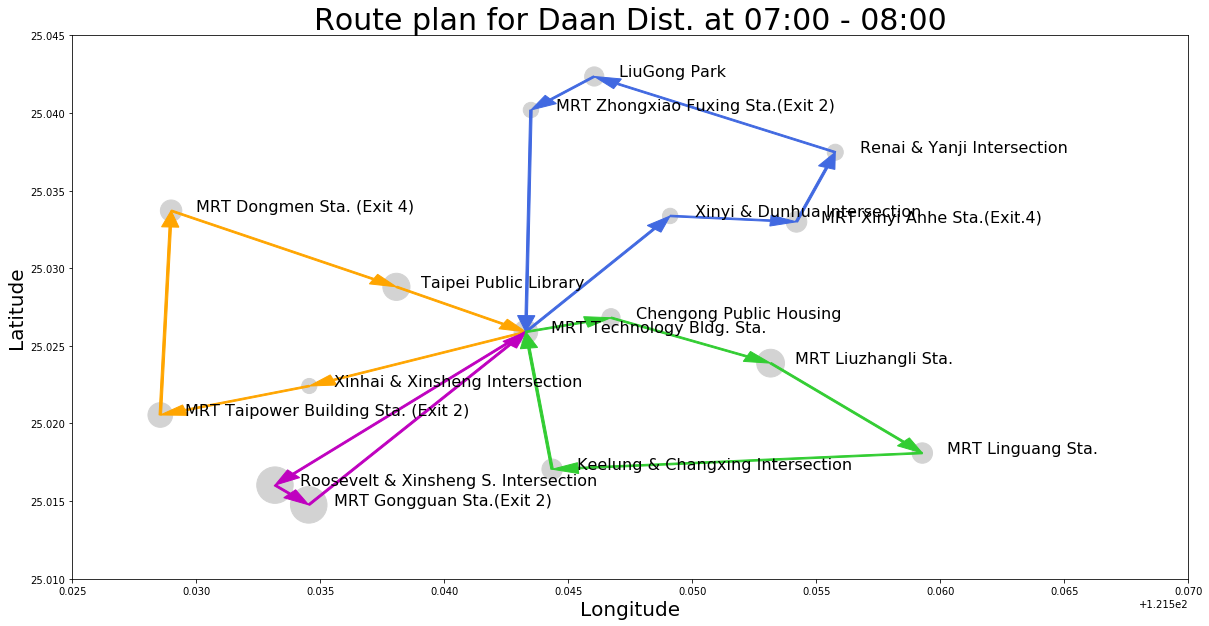

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Route plan for Daan Dist. at 07:00 - 08:00', fontsize=30)
ax.scatter(df_ta['lng'], df_ta['lat'], s=df_ta['demand']*4, color='lightgrey')
ax.set(xlim=[121.525, 121.57], ylim=[25.01, 25.045])
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
for i, txt in enumerate(df_ta['snaen']):
    ax.annotate(txt, (df_ta['lng'][i] + 0.001, df_ta['lat'][i]), fontsize=16)

# Route plan for Daan Dist. at 07:00 - 08:00
v0 = [0, 2, 8, 4, 6, 0]
v1 = [0, 12, 5, 0]
v2 = [0, 9, 7, 15, 14, 10, 0]
v3 = [0, 11, 3, 13, 1, 0]

def plot_arrow(a, b, color):
    ax.arrow(df_ta['lng'][a], df_ta['lat'][a], (df_ta['lng'][b] - df_ta['lng'][a]), (df_ta['lat'][b] - df_ta['lat'][a]), length_includes_head=True, width=0.0001, head_width=0.0007, fc=color, ec=color)
    return

for i in range(len(v0) - 1):
    plot_arrow(v0[i], v0[i+1], 'orange')
for i in range(len(v1) - 1):
    plot_arrow(v1[i], v1[i+1], 'm')
for i in range(len(v2) - 1):
    plot_arrow(v2[i], v2[i+1], 'royalblue')
for i in range(len(v3) - 1):
    plot_arrow(v3[i], v3[i+1], 'limegreen')